# Evaluation and Serving of the LSTM with Attention, Improved Performance in Production and Edge Cases
This notebook is part 3 of the series, Ultimate-ai-challenge. It is the most fun notebook, because it detects the model failures, and improves the model performance by using chatgpt. Such distillation approaches are appearning in blogs.

I continue: after tuning hyperparameters in part 2, I demonstrate the process of evaluating, and serving an LSTM model with attention for intent classification on the ATIS dataset. I evaluate the model using different metrics 
1. Accuracy
2. Precision
3. Recall
4. Support
5. ROC curve, confusion matrix, classification report, etc..

One of the critical outcomes of this work how do I measure performance during production and then take improvement measures.
## Improving model performace in production and handling edge cases 
also add some test/edge cases to show that how the model performance can be improved in production or how the out-of-sample detection can be made better. There can be many strategies to check the model performance in production. However I only work on two
### 1. Confidence Scores
### 2. Out-of-Sample Detection


Lets start!!

In [2]:
### Important Note; carefully set the project Root, so relative class imports work.
import os
marker = '.git'  # Replace with your unique marker file or directory
while not os.path.exists(marker):
    os.chdir('..')
# Verify the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/ahmedjawad/Documents/JobSearch/UltimateAIChallenge/ultimate_aiv2


In [3]:
import pandas as pd
from machine_learning.learners.IntentTokenizer import IntentTokenizer
from machine_learning.learners.model_utils import train, evaluate, predict, get_or_create_experiment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import warnings
import mlflow
from machine_learning.learners.model_utils import get_or_create_experiment
import torch.optim as optim
import torch.nn as nn
import torch
import optuna
import logging
import sys
from torch.utils.data import DataLoader
# Reload Optuna Study to get the best parameters
warnings.filterwarnings('ignore')


inside IntentTokenizer
Actual Vocabulary Size: 890
Encoding labels for the first time and adding unknown class.
Label Encoding: {'abbreviation': 0, 'aircraft': 1, 'aircraft+flight+flight_no': 2, 'airfare': 3, 'airfare+flight_time': 4, 'airline': 5, 'airline+flight_no': 6, 'airport': 7, 'capacity': 8, 'cheapest': 9, 'city': 10, 'distance': 11, 'flight': 12, 'flight+airfare': 13, 'flight_no': 14, 'flight_time': 15, 'ground_fare': 16, 'ground_service': 17, 'ground_service+ground_fare': 18, 'meal': 19, 'quantity': 20, 'restriction': 21, '<unknown>': 22}
Using device: mps
Number of training samples: torch.Size([4634, 46])
Number of training batches: 145
Number of test samples: torch.Size([850, 30])
Number of test batches: 27


In [4]:
# Determine the computation device based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(f"Using device: {device}")


Using device: mps


#### Load the tokenizers and test datasets
In the previous notebook, I saved the model with the best validation loss, trained tokenizer and label encoder to disk. I load them here to use for processing the test data. Note that there are other parameter combinations that had a better test accuracy, but one cannot look into test data at the training time. Therefore the only way to choose the best model is to use validation data. I will use the best model for serving and evaluation. It can be a future to do to study the impact of different hyperparameters on the model performance on the test data.

In [5]:
# Specify the model name for loading
from machine_learning.pipelines.data_loaders import test_df, test_data, test_loader
# Load the trained model and tokenizer from saved files
batch_size=32
model_name = "best_ICELSTMAmodel"
model = torch.load(f"data/models/{model_name}.pth").to(device)
tokenizer = IntentTokenizer.load_state(IntentTokenizer,f"data/models/{model_name}_tokenizer.pickle", f"data/models/{model_name}_le.pickle")

## Model Metrics: Evaluate the model on the test dataset
The following methods are used for evaluation:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix
- Precision-Recall Curve
- ROC Curve
- Classification Report

In [6]:
# Extract true labels from the test data
y_test = test_df['label'].values

# Predict labels using the trained model
y_pred = predict(model, test_df, tokenizer, device)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display the computed metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9705882352941176
Precision: 0.9693377439617544
Recall: 0.9705882352941176
F1 Score: 0.9687628372888645
                precision    recall  f1-score   support

     <unknown>       0.00      0.00      0.00         5
  abbreviation       1.00      1.00      1.00        26
      aircraft       1.00      0.88      0.93         8
       airfare       0.96      0.98      0.97        48
       airline       1.00      0.96      0.98        28
       airport       1.00      0.85      0.92        13
      capacity       1.00      0.90      0.95        21
          city       0.80      0.80      0.80         5
      distance       1.00      0.90      0.95        10
        flight       0.98      0.99      0.98       613
flight+airfare       0.89      0.67      0.76        12
     flight_no       1.00      1.00      1.00         8
   flight_time       1.00      1.00      1.00         1
   ground_fare       1.00      0.86      0.92         7
ground_service       0.97      1.00      0.9

#### Visualize the confusion matrix


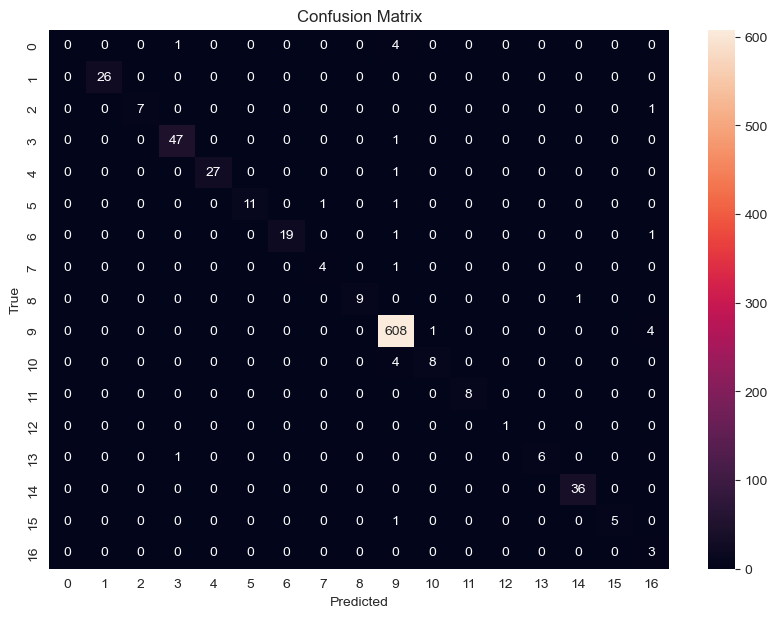

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


One can make interesting observations about class distributions and prediction failures from confusion matrix. Let's discuss laters

#### Visualize the precision-recall curve and ROC curve

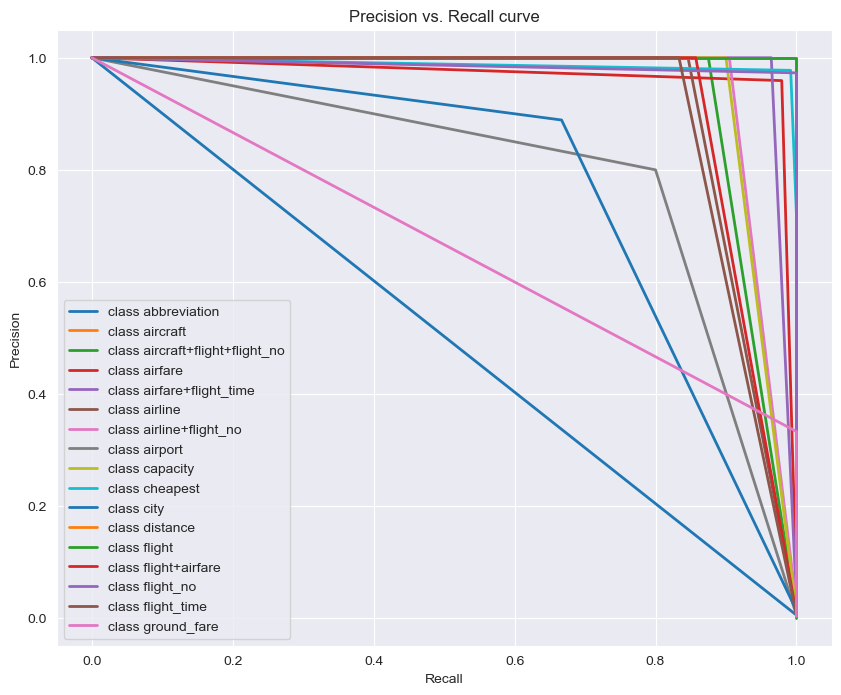

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class plots
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_test))

n_classes = y_test_binarized.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {tokenizer.le.classes_[i]}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

### Visualize ROC curve

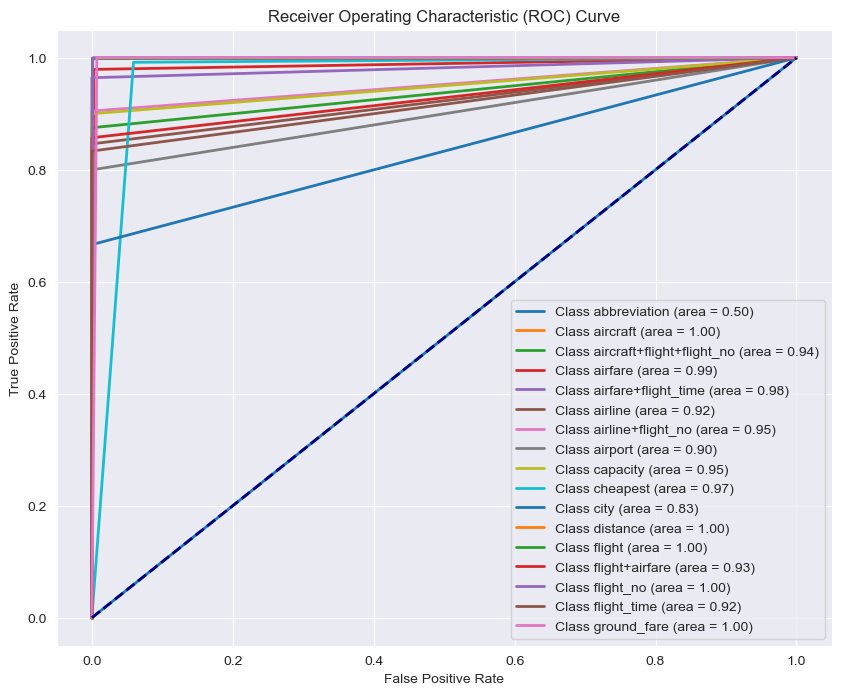

In [9]:

from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {tokenizer.le.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Serve the model for prediction , Evaluate Production Performance**

1. **Confidence Score Analysis** :
Confidence Distribution: Analyze the distribution of confidence scores for predictions. A well-performing model should generally have higher confidence scores.
Threshold Analysis: Determine how varying confidence thresholds affect the number of predicted intents. A stable model will show a consistent pattern in the distribution of predictions above certain confidence levels.

2. **Error Analysis**
Manual Review: Randomly sample a set of predictions and manually review them. This can provide qualitative insights into types of errors (e.g., systematic errors, rare cases).
Consistency Check: For applications with user feedback loops (like chatbots), monitor user actions following the model's response. Frequent user corrections or negative feedback can indicate issues.

3. **Out-of-Distribution (OOD) Detection**
OOD Samples: Use a separate dataset that the model hasn't seen, preferably containing out-of-distribution samples. Measure how the model's confidence scores differ on these samples.
OOD Metrics: Evaluate using metrics like Area Under the Receiver Operating Characteristic curve (AUROC) for OOD detection efficiency.

4. **Comparative Analysis**
A/B Testing: If possible, implement A/B testing where different models serve different user segments. Monitor indirect metrics like user engagement, session length, or conversion rates.
Sequential Testing: Periodically switch between models in production and monitor overall system performance metrics.

5. **Model Drift Monitoring**
Data Drift: Monitor for shifts in input data distribution over time. Significant drifts can suggest that the model might be becoming less effective.
rediction Drift: Monitor changes in the distribution of the model's predictions. A sudden shift could indicate that the model's performance is degrading.

6. **Feedback Loop**
User Feedback: Implement a mechanism for users to provide feedback on predictions. This can be direct (like thumbs up/down) or inferred (like user ignoring the model's suggestion).

7. **Additional Metrics**
Latency: Measure the response time. A slower model might impact user experience negatively.
Resource Utilization: Monitor CPU, memory, and other resource usages. An efficient model should balance accuracy with resource consumption.

# Production time serving and edge cases
### Implementing confidence scores
### 1. Extracting Confidence Scores:
When making predictions with your model, you'll usually obtain not only the predicted labels but also the probabilities associated with each class. These probabilities can be interpreted as confidence scores.
For a given input text, the model outputs a confidence score for each possible intent. The intent with the highest score is typically chosen as the prediction.
### 2. Analyzing Confidence Scores:
Histogram of Confidence Scores: Plot a histogram of the confidence scores of all predictions. This will give you an idea of how certain the model is about its predictions. A well-performing model will have a distribution skewed towards higher confidence scores.
Average Confidence Score: Calculate the average confidence score across all predictions. A higher average indicates higher overall confidence of the model in its predictions.
### 3. Confidence Threshold Analysis:
Determine how different confidence thresholds affect the number of predicted intents and their perceived accuracy. For example, you might analyze how many predictions have confidence above 0.9, 0.8, etc.
Observing the drop-off in the number of predictions above certain confidence levels can provide insights into the model’s reliability.
### 4. Segment Analysis:
Break down the confidence scores by different segments such as time of day, user demographics, or type of query. This can help identify if the model performs consistently across different segments or if there are specific areas where confidence is notably lower.
### 6. Interpretation:
High Confidence, Poor Accuracy: If the model shows high confidence but poor accuracy, this might indicate overfitting or issues with the training data.
Low Confidence: Consistently low confidence scores might suggest the model is underfitting or not complex enough to capture the nuances of the data.
### 7. Use in Production:
Implement logging of confidence scores in your production system.
Regularly analyze these logs to monitor model performance.
Use the insights from this analysis for model retraining or adjustment decisions.
Remember, this analysis is part of a continuous monitoring strategy and should be adapted and expanded based on specific use cases and available data.

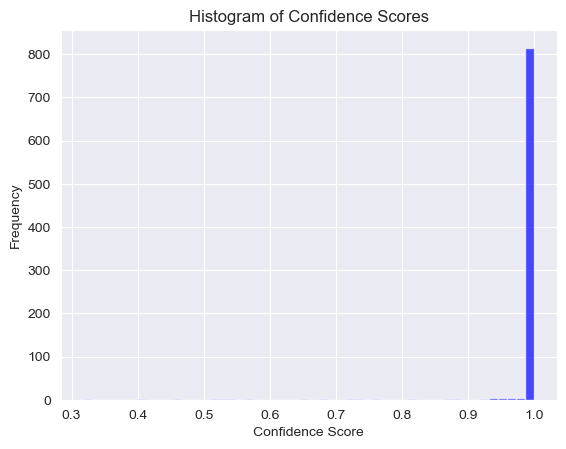

Average Confidence Score: 0.99


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
batch_size=32



confidence_scores = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probabilities, dim=1)
        confidence_scores.extend(max_probs.cpu().numpy())

# Plotting histogram of confidence scores
plt.hist(confidence_scores, bins=50, alpha=0.7, color='blue')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Histogram of Confidence Scores')
plt.show()

# Calculating and printing average confidence score
average_confidence = np.mean(confidence_scores)
print(f'Average Confidence Score: {average_confidence:.2f}')

# OOS case: "I want to book a hotel room near Miami Beach", 
## How will the model respond?

The first guess is that the model will be wrong

In [11]:

# Your query string
query_str = "I want to book a hotel room near Miami Beach"
# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
y_pred= predict(model, query, tokenizer, device)
y_pred

array(['flight'], dtype=object)

# BAD NEWS!! Booking a hotel room has no relation to flights.
Out-of-Sample Detection is poor


# Out-of-Distribution (OOD) Detection 

is crucial for neural network models, especially in a production environment, to identify when a model is making predictions on data that is significantly different from the data it was trained on. Here's how you can approach OOD detection:

#### I created two Out-of-Sample files ood.tsv and ood_test.csv by asking chatgpt to include some edge cases. Their purpose will become clear later on

Number of ood samples: torch.Size([80, 12])
Number of ood samples: torch.Size([70, 12])


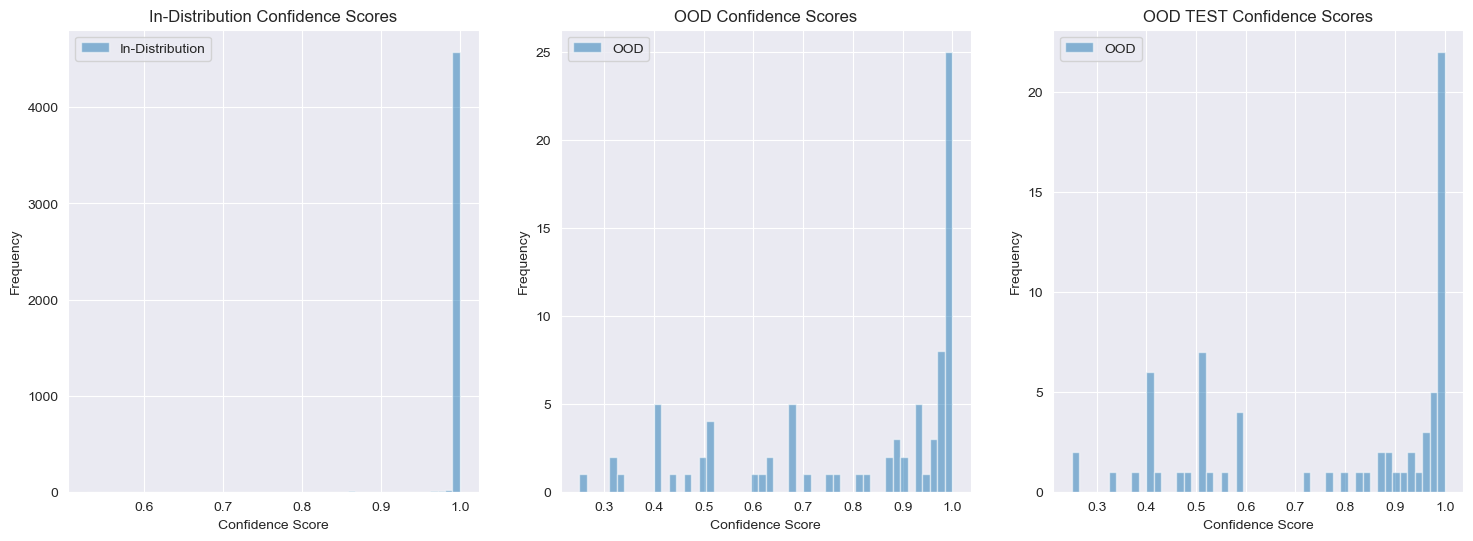

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

batch_size=32
# Load the trained model and tokenizer from saved files
model_name = "best_ICELSTMAmodel"
model = torch.load(f"data/models/{model_name}.pth").to(device)
def get_confidence_scores(model, data_loader):
    model.eval()
    confidence_scores = []
    with torch.no_grad():
        for inputs,_ in data_loader:
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probabilities, dim=1)
            confidence_scores.extend(max_probs.cpu().numpy())
    return confidence_scores

train_df = pd.read_csv('data/input/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

ood_df=pd.read_csv('data/input/atis/ood.tsv', sep='\t', header=None, names=["text", "label"])
ood_data = tokenizer.process_data(ood_df, device=device)
ood_loader= DataLoader(ood_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_data.tensors[0].size())


ood_test_df=pd.read_csv('data/input/atis/ood_test.tsv', sep='\t', header=None, names=["text", "label"])
ood_test_data = tokenizer.process_data(ood_test_df, device=device)
ood_test_loader= DataLoader(ood_test_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_test_data.tensors[0].size())


# Assuming train_loader and ood_loader are DataLoader objects for your in-distribution and OOD data
train_confidence_scores = get_confidence_scores(model, train_loader)
ood_confidence_scores = get_confidence_scores(model, ood_loader)
ood_test_confidence_scores = get_confidence_scores(model, ood_test_loader)


# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting histograms on subplots
axs[0].hist(train_confidence_scores, bins=50, alpha=0.5, label='In-Distribution')
axs[0].set_title('In-Distribution Confidence Scores')
axs[0].set_xlabel('Confidence Score')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(ood_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[1].set_title('OOD Confidence Scores')
axs[1].set_xlabel('Confidence Score')
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].hist(ood_test_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[2].set_title('OOD TEST Confidence Scores')
axs[2].set_xlabel('Confidence Score')
axs[2].set_ylabel('Frequency')
axs[2].legend()
# Displaying the plots
plt.show()

### CHECK THE ACTUAL PREDICTIONS ON OOD AND OOD_TEST,
As you can see above, the confidence for OOS samples is poor. Below, all non related samples are labelled and not assigned unknown buckets. This is poor performance.

In [14]:
print("How the model performs on OOD data")
y_pred=predict(model, ood_df, tokenizer, device)
print(y_pred)

print("How the model performs on OOD data Test")
y_pred=predict(model, ood_test_df, tokenizer, device)
print(y_pred)

How the model performs on OOD data
['flight' 'ground_service' 'abbreviation' 'flight' 'flight' 'flight'
 'flight_time' 'flight_time' 'abbreviation' 'flight_time' 'abbreviation'
 'flight' 'ground_service' 'flight' 'flight' 'flight_time' 'city'
 'abbreviation' 'distance' 'restriction' 'flight' 'flight'
 'ground_service' 'flight' 'flight_time' 'flight' 'city' 'flight'
 'abbreviation' 'flight' 'abbreviation' 'ground_service' 'city' 'airfare'
 'ground_service' 'flight' 'abbreviation' 'abbreviation' 'flight' 'flight'
 'city' 'flight' 'abbreviation' 'flight' 'city' 'flight' 'flight' 'flight'
 'flight' 'flight' 'flight' 'abbreviation' 'flight' 'flight' 'flight'
 'abbreviation' 'flight' 'flight' 'city' 'flight' 'flight' 'flight'
 'flight' 'flight' 'flight' 'flight' 'flight_time' 'flight' 'abbreviation'
 'ground_service' 'flight' 'abbreviation' 'restriction' 'flight' 'flight'
 'ground_service' 'flight' 'abbreviation' 'restriction' 'flight']
How the model performs on OOD data Test
['abbreviation'

In [15]:
ood_df

,text,label
0,Book a room at the Hilton for next weekend ...,<unknown>
1,What's the weather like in Miami today? <un...,<unknown>
2,Can you find me a sushi restaurant nearby? ...,<unknown>
3,I need directions to the nearest gas station ...,<unknown>
4,What movies are playing tonight? <unknown>,<unknown>
...,...,...
75,Where can I find a professional life coach? ...,<unknown>
76,How to bake a vegan chocolate cake? <unknown>,<unknown>
77,What are the best exercises for a flat stomach...,<unknown>
78,Can you recommend a good documentary on nature...,<unknown>


### Improving the model by adding an on ood_sample in the training data
The output above shows very worrying picture, the whole out of sample data is labelled according to known class. Therefore to make the out-of-sample detection better, I generate some fake training data for out of sample using chatgpt and add it to the training data to get ood detection better. This is akin to fine tuning with additional data in the training data.

In [17]:

model_class_name = "IntentClassifierLSTMWithAttention"
model_name = "best_ICELSTMAmodel"
model = torch.load(f"data/models/{model_name}.pth").to(device)
experiment_id = get_or_create_experiment(model_class_name)
mlflow.set_experiment(experiment_id=experiment_id)
storage = optuna.storages.RDBStorage(url=f"sqlite:///data/db/{model_class_name}.db")
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout));
study = optuna.create_study(study_name=model_class_name, storage=storage,load_if_exists=True,direction="maximize");
best_trial = study.best_trial
print(f'Best trial: score {best_trial.value:.4f},\nparams {best_trial.params}')


train_df = pd.read_csv('data/input/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
ood_df=pd.read_csv('data/input/atis/ood.tsv', sep='\t', header=None, names=["text", "label"])
ood_data = tokenizer.process_data(ood_df, device=device)
ood_loader= DataLoader(ood_data, shuffle=True, batch_size=batch_size)

## *****Adding OOD Data to Training Data ****##
train_df=pd.concat([train_df,ood_df])
train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
with mlflow.start_run():
    # Log the best parameters
    lr=best_trial.params['lr']
    weight_decay=best_trial.params['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    train_loss = train(model, optimizer, nn.CrossEntropyLoss(), train_loader, 20)
    test_accuracy = evaluate(model, nn.CrossEntropyLoss(), test_loader, data_type="Test")
    print(f'Test Accuracy: {test_accuracy:.4f}')
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss)
    mlflow.pytorch.log_model(model, f"best_model_ood")
# Saving the model to avoid ambiguity later

print(f"model_class_name={model_class_name}")
model_name = "best_ICELSTMAmodel_ood"
torch.save(model, f"data/models/{model_name}.pth")
print("model: "+model_name+" is saved")


[I 2023-11-25 01:21:36,252] Using an existing study with name 'IntentClassifierLSTMWithAttention' instead of creating a new one.


Using an existing study with name 'IntentClassifierLSTMWithAttention' instead of creating a new one.
Using an existing study with name 'IntentClassifierLSTMWithAttention' instead of creating a new one.
Best trial: score 0.9903,
params {'lr': 0.0013487934809448435, 'hidden_dim': 64, 'embedding_dim': 128, 'dropout_rate': 0.17918187700846566, 'weight_decay': 4.75333827188117e-05}
Epoch [1/20], Loss: 0.0489, Accuracy: 0.9894
Test Loss: 0.2711
Test Accuracy: 0.9565
Epoch [2/20], Loss: 0.0418, Accuracy: 0.9905
Test Loss: 0.2462
Test Accuracy: 0.9565
Epoch [3/20], Loss: 0.0567, Accuracy: 0.9847
Test Loss: 0.2672
Test Accuracy: 0.9447
Epoch [4/20], Loss: 0.0573, Accuracy: 0.9847
Test Loss: 0.2540
Test Accuracy: 0.9541
Epoch [5/20], Loss: 0.0561, Accuracy: 0.9849
Test Loss: 0.2217
Test Accuracy: 0.9612
Epoch [6/20], Loss: 0.0513, Accuracy: 0.9868
Test Loss: 0.2157
Test Accuracy: 0.9541
Epoch [7/20], Loss: 0.0528, Accuracy: 0.9879
Test Loss: 0.2108
Test Accuracy: 0.9588
Epoch [8/20], Loss: 0.059

***The Best Model in terms of hyperparameter selection is fine tuned on the out-of-sample data created by chatgpt, a distillation process***

### OOS test file is still unseen from the model. I check confidence scores on performance on it

As you can see the confidence score and performance has improved a lot in the following analysis

Number of ood samples: torch.Size([80, 12])
Number of ood samples: torch.Size([70, 12])


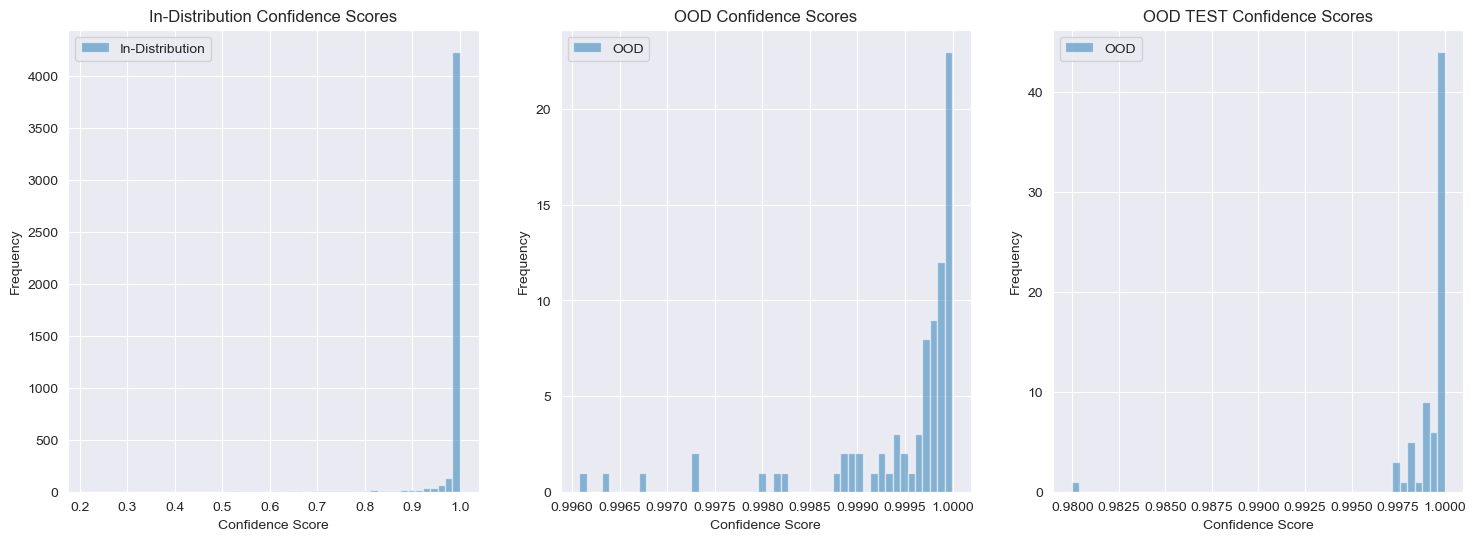

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

batch_size=5000
model_name = "best_ICELSTMAmodel_ood"
model=torch.load(f"data/models/{model_name}.pth")

def get_confidence_scores(model, data_loader):
    model.eval()
    confidence_scores = []
    with torch.no_grad():
        for inputs,_ in data_loader:
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probabilities, dim=1)
            confidence_scores.extend(max_probs.cpu().numpy())
    return confidence_scores

train_df = pd.read_csv('data/input/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

ood_df=pd.read_csv('data/input/atis/ood.tsv', sep='\t', header=None, names=["text", "label"])
ood_data = tokenizer.process_data(ood_df, device=device)
ood_loader= DataLoader(ood_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_data.tensors[0].size())


ood_test_df=pd.read_csv('data/input/atis/ood_test.tsv', sep='\t', header=None, names=["text", "label"])
ood_test_data = tokenizer.process_data(ood_test_df, device=device)
ood_test_loader= DataLoader(ood_test_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_test_data.tensors[0].size())


# Assuming train_loader and ood_loader are DataLoader objects for your in-distribution and OOD data
train_confidence_scores = get_confidence_scores(model, train_loader)
ood_confidence_scores = get_confidence_scores(model, ood_loader)
ood_test_confidence_scores = get_confidence_scores(model, ood_test_loader)


# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting histograms on subplots
axs[0].hist(train_confidence_scores, bins=50, alpha=0.5, label='In-Distribution')
axs[0].set_title('In-Distribution Confidence Scores')
axs[0].set_xlabel('Confidence Score')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(ood_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[1].set_title('OOD Confidence Scores')
axs[1].set_xlabel('Confidence Score')
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].hist(ood_test_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[2].set_title('OOD TEST Confidence Scores')
axs[2].set_xlabel('Confidence Score')
axs[2].set_ylabel('Frequency')
axs[2].legend()
# Displaying the plots
plt.show()


### Confidence and Predictions Improved for OODs.

In [22]:
print("How the model performs on OOD data")
y_pred=predict(model, ood_df, tokenizer, device)
print(y_pred)

print("How the model performs on OOD data Test")
y_pred=predict(model, ood_test_df, tokenizer, device)
print(y_pred)

How the model performs on OOD data
['<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<u

***The Performance is much improved on the unseen data now. I did LLM fine tuning here :)***

In [23]:
# Save the model as our final model for serving
class_name=model.__class__.__name__
print(class_name)
print(f"class_name={class_name}")
model.save_config_file(f"config/{class_name}.json")
torch.save(model.state_dict(),f"data/models/{class_name}_state_dict.pth")
tokenizer.save_state(f"data/models/{class_name}_tokenizer.pickle", f"data/models/{class_name}_le.pickle")

IntentClassifierLSTMWithAttention
class_name=IntentClassifierLSTMWithAttention


## Check close call/Edge messages and model responses
Check "I want to book a hotel room near Miami Beach" by both Models

In [24]:
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_without_ood = torch.load(f"data/models/{model_name}.pth").to(device)
model_with_ood = torch.load(f"data/models/{model_name}_ood.pth").to(device)

# Your query string
query_str = "I want to book a hotel room near miami beach"

# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
print("Model trained without OOD, Response=" + predict(model_without_ood, query, tokenizer, device))
print("Model trained with OOD, Response=" + predict(model_with_ood, query, tokenizer, device))


['Model trained without OOD, Response=flight']
['Model trained with OOD, Response=<unknown>']


## Check "what a bizzare situation, I had not expected it"

In [25]:
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_without_ood = torch.load(f"data/models/{model_name}.pth").to(device)
# Your query string
query_str = "what a bizzare situation this is bot"

# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
print("Model trained without OOD, Response=" + predict(model_without_ood, query, tokenizer, device))
print("Model trained with OOD, Response=" + predict(model_with_ood, query, tokenizer, device))

['Model trained without OOD, Response=abbreviation']
['Model trained with OOD, Response=<unknown>']


In [26]:
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_without_ood = torch.load(f"data/models/{model_name}.pth").to(device)
# Your query string
query_str = "Book me a flight from miami to chicago"

# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
print("Model trained without OOD, Response=" + predict(model_without_ood, query, tokenizer, device))
print("Model trained with OOD, Response=" + predict(model_with_ood, query, tokenizer, device))

['Model trained without OOD, Response=flight']
['Model trained with OOD, Response=flight']


In [27]:
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_without_ood = torch.load(f"data/models/{model_name}.pth").to(device)
# Your query string
query_str = "life would be good if you had a seat for me in the plane"

# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
print("Model trained without OOD, Response=" + predict(model_without_ood, query, tokenizer, device))
print("Model trained with OOD, Response=" + predict(model_with_ood, query, tokenizer, device))

['Model trained without OOD, Response=flight_time']
['Model trained with OOD, Response=<unknown>']
